<a href="https://colab.research.google.com/github/surajn581/covid19_detection/blob/master/Modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
base_path = '/content/drive/My Drive/Colab Notebooks/covid19_detection'

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
train_path = "/content/drive/My Drive/Colab Notebooks/covid19_detection/train_data"
test_path = "/content/drive/My Drive/Colab Notebooks/covid19_detection/test_data"
labels = ["covid", "healthy", "noncovid"]

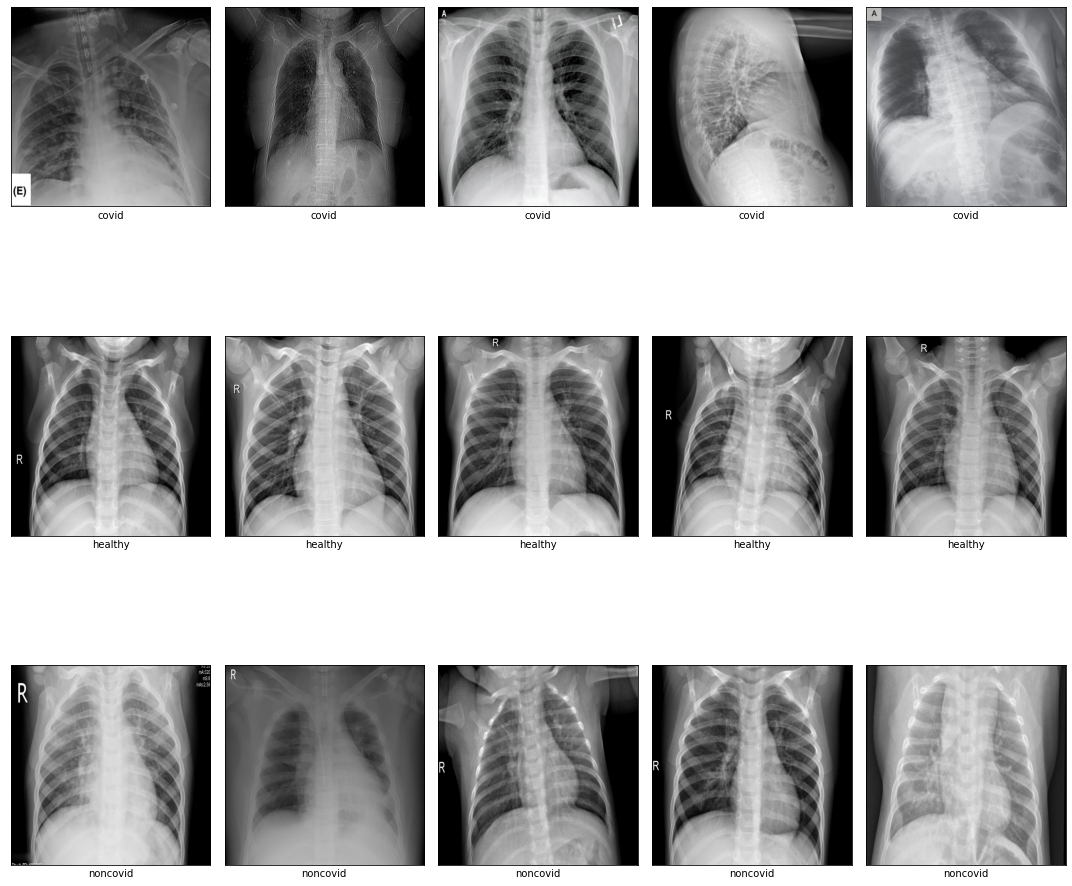

In [5]:
# Randomly view 5 images in each category

fig, axs = plt.subplots(len(labels), 5, figsize = (15, 15))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(train_path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])

fig.tight_layout()

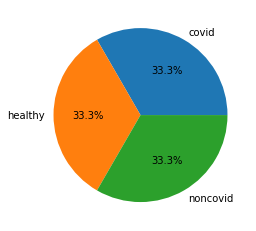

In [6]:
# Make a pie-chart to visualize the percentage contribution of each category.
fig, ax = plt.subplots()
ax.pie(
    class_len.values(),
    labels = class_len.keys(),
    autopct = "%1.1f%%"
)
fig.show()
# The dataset is imbalance so we will have to take care of that later.

In [7]:
# We need to read training and validation images from the seperate folder such that:
# 1. There is no data leak i.e. Training images should not appear as validation images.                 
# 2. We must be able to apply augmentation to training images but not validation images.  
# We shall adopt the following strategy:
# 1. Use the same validation_split in ImageDataGenerator for training and validation.
# 2. Use the same seed when using flow_from_directory for training and validation. 
# To veify the correctness of this approach, you can print filenames from each generator and check for overlap.

# Another problem is that along with the 3 image data folders, there are files we are not making use of.
# To be sure that images are read from the correct folders, we can specify the directory and the labels.

# Note that we use simple augmentation to avoid producing unsuitable images.

img_height, img_width=224,224

datagen_train = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 5,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.01
)

datagen_val = ImageDataGenerator(
    rescale = 1./255
)    

train_generator = datagen_train.flow_from_directory(
    directory = train_path,
    classes = labels,
    target_size=(img_height, img_width),
    seed = 42,
    batch_size = 32, 
    shuffle = True,
    subset = 'training'
)

val_generator = datagen_val.flow_from_directory(
    directory = test_path,
    classes = labels,
    target_size=(img_height, img_width),
    seed = 42,
    batch_size = 32, 
    shuffle = True,
    subset = 'validation'
)

Found 120 images belonging to 3 classes.
Found 0 images belonging to 3 classes.


In [8]:
# To veify the correctness of this approach (empty set is expected)
set(val_generator.filenames).intersection(set(train_generator.filenames))

set()

In [9]:
# Check out labeling
val_generator.class_indices

{'covid': 0, 'healthy': 1, 'noncovid': 2}

In [10]:
def generate_vgg16_model():
    
    model = Sequential()

    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=3, activation="softmax"))
    
    return model

In [11]:
model = generate_vgg16_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [13]:
# Compile the model

# Given that COVID-19 spreads very quickly, it is important that we identify as many cases as possible.
# We do not care a lot about Flase Positives (precision), because it may be okay to declare normal people as being COVID-19 positive.
# However, we really really care about False Negatives (recall), because it is NOT okay to declare COVID-19 positive people as being normal!

MyList = ["accuracy"]
MyList += [Recall(class_id = i) for i in range(len(labels))] 
MyList += [Precision(class_id = i) for i in range(len(labels))]

model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = Adam(0.0001),
    metrics = MyList
)

In [15]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = "recall",
    patience = 20
)

# save the best model with lower loss
checkpointer = ModelCheckpoint(
    filepath = "weights.hdf5", 
    save_best_only = True
)

In [16]:
# Previously we found that there was class imbalance. 
# We shall use class weights to tackle this before moving to training.

total_wt = sum(class_len.values())

weights = {
    0: 0.5 * (1 - class_len[labels[0]]/total_wt),
    1: 0.5 * (1 - class_len[labels[1]]/total_wt),
    2: 0.5 * (1 - class_len[labels[2]]/total_wt)
}
weights

{0: 0.33333333333333337, 1: 0.33333333333333337, 2: 0.33333333333333337}

In [21]:
#  Finally, fit the neural network model to the data.

history = model.fit_generator(
    train_generator,
    class_weight = weights,
    validation_data = train_generator,
    epochs = 10, 
    callbacks = [earlystopping, checkpointer]
)

Epoch 1/10
4/4 [==============================] - 16s 4s/step - loss: 0.1279 - accuracy: 0.8833 - recall: 0.8750 - recall_1: 0.9000 - recall_2: 0.7500 - precision: 0.9722 - precision_1: 0.8571 - precision_2: 0.8571 - val_loss: 0.3073 - val_accuracy: 0.8583 - val_recall: 0.8000 - val_recall_1: 0.8750 - val_recall_2: 0.9000 - val_precision: 1.0000 - val_precision_1: 0.8974 - val_precision_2: 0.7826
Epoch 2/10
4/4 [==============================] - 7s 2s/step - loss: 0.0981 - accuracy: 0.8667 - recall: 0.9000 - recall_1: 0.8250 - recall_2: 0.8750 - precision: 0.9730 - precision_1: 0.8919 - precision_2: 0.7778 - val_loss: 0.3334 - val_accuracy: 0.8500 - val_recall: 1.0000 - val_recall_1: 1.0000 - val_recall_2: 0.5500 - val_precision: 0.8696 - val_precision_1: 0.7692 - val_precision_2: 1.0000
Epoch 3/10
4/4 [==============================] - 7s 2s/step - loss: 0.1280 - accuracy: 0.8833 - recall: 0.9750 - recall_1: 0.9250 - recall_2: 0.7500 - precision: 0.9070 - precision_1: 0.8605 - precisi

Text(0.5, 1.0, 'Training and Validation Loss')

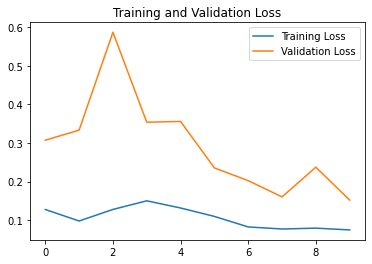

In [22]:
# Plotting training and validation loss per epoch

train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

epochs = range(len(train_loss)) 

plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Training and Validation Loss")

Text(0.5, 1.0, 'Training and Validation Accuracy')

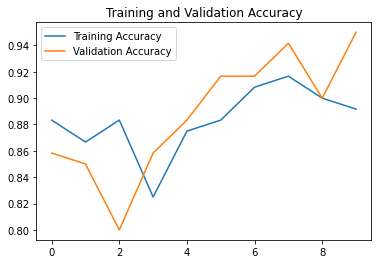

In [23]:
# Plotting training and validation accuracy per epoch

train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

epochs = range(len(train_acc)) 

plt.plot(epochs, train_acc)
plt.plot(epochs, valid_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Training and Validation Accuracy")

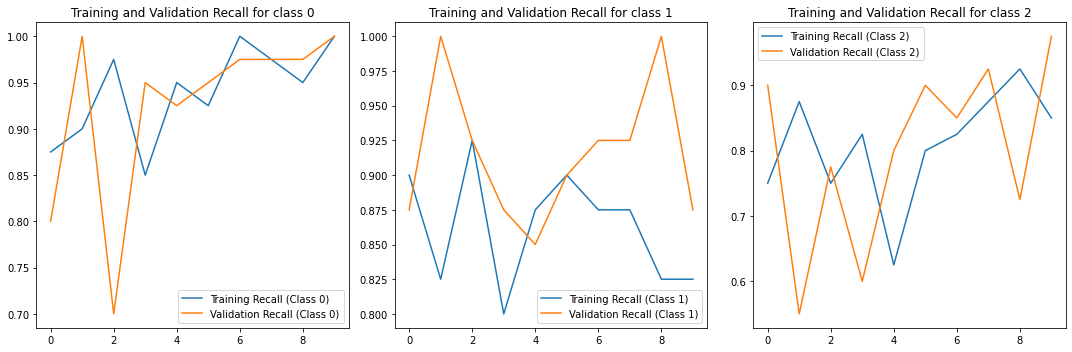

In [24]:
# Plotting training and validation recall per epoch

fig, axs = plt.subplots(1, 3, figsize = (15, 5))

train_rec_0 = history.history["recall"]
valid_rec_0 = history.history["val_recall"]
train_rec_1 = history.history["recall_1"]
valid_rec_1 = history.history["val_recall_1"]
train_rec_2 = history.history["recall_2"]
valid_rec_2 = history.history["val_recall_2"]

epochs = range(len(train_rec_0)) 

axs[0].plot(epochs, train_rec_0)
axs[0].plot(epochs, valid_rec_0)
axs[0].legend(["Training Recall (Class 0)", "Validation Recall (Class 0)"])
axs[0].set_title("Training and Validation Recall for class 0")

axs[1].plot(epochs, train_rec_1)
axs[1].plot(epochs, valid_rec_1)
axs[1].legend(["Training Recall (Class 1)", "Validation Recall (Class 1)"])
axs[1].set_title("Training and Validation Recall for class 1")

axs[2].plot(epochs, train_rec_2)
axs[2].plot(epochs, valid_rec_2)
axs[2].legend(["Training Recall (Class 2)", "Validation Recall (Class 2)"])
axs[2].set_title("Training and Validation Recall for class 2")

fig.tight_layout()

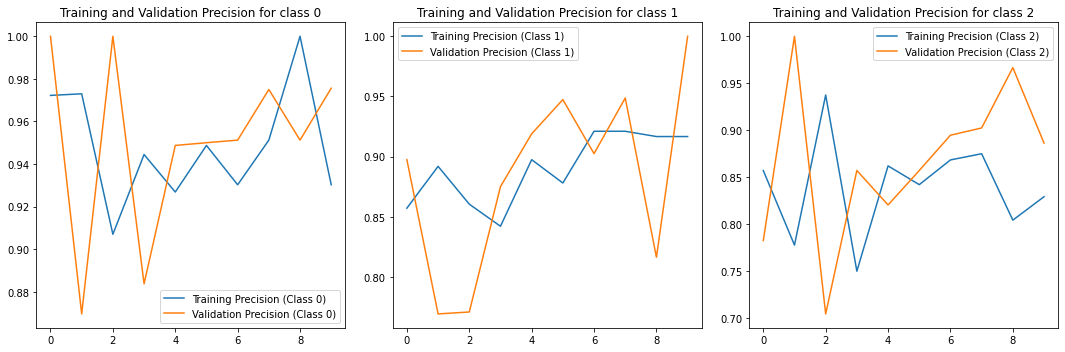

In [25]:
# Plotting training and validation precision per epoch

fig, axs = plt.subplots(1, 3, figsize = (15, 5))

train_pre_0 = history.history["precision"]
valid_pre_0 = history.history["val_precision"]
train_pre_1 = history.history["precision_1"]
valid_pre_1 = history.history["val_precision_1"]
train_pre_2 = history.history["precision_2"]
valid_pre_2 = history.history["val_precision_2"]

epochs = range(len(train_pre_0)) 

axs[0].plot(epochs, train_pre_0)
axs[0].plot(epochs, valid_pre_0)
axs[0].legend(["Training Precision (Class 0)", "Validation Precision (Class 0)"])
axs[0].set_title("Training and Validation Precision for class 0")

axs[1].plot(epochs, train_pre_1)
axs[1].plot(epochs, valid_pre_1)
axs[1].legend(["Training Precision (Class 1)", "Validation Precision (Class 1)"])
axs[1].set_title("Training and Validation Precision for class 1")

axs[2].plot(epochs, train_pre_2)
axs[2].plot(epochs, valid_pre_2)
axs[2].legend(["Training Precision (Class 2)", "Validation Precision (Class 2)"])
axs[2].set_title("Training and Validation Precision for class 2")

fig.tight_layout()

Found 30 images belonging to 3 classes.


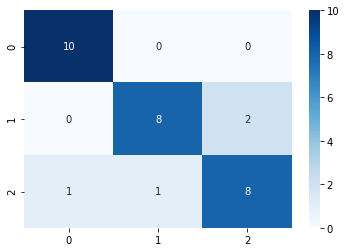

In [29]:
# Confusion Matrix 

# Since we do not have a lot of data, we did not split into training-validation-testing.
# Instead we split into training-validation.
# we shall use images in validation dataset for testing. 

# There is one problem. Previously, we set shuffle = True in our generator.
# This makes it difficult to obtain predictions and their corresponding ground truth labels.
# Thus, we shall call the generator again, but this time set shuffle = False.
train_path = "/content/drive/My Drive/Colab Notebooks/covid19_detection/train_data"
test_path = "/content/drive/My Drive/Colab Notebooks/covid19_detection/test_data"

val_generator = datagen_train.flow_from_directory(
    directory = train_path,
    classes = labels,
    target_size=(img_height, img_width),
    seed = 42,
    batch_size = 32, 
    shuffle = False,
    subset = 'validation'
)

# Obtain predictions
pred = model.predict_generator(val_generator) # Gives class probabilities
pred = np.round(pred) # Gives one-hot encoded classes
pred = np.argmax(pred, axis = 1) # Gives class labels

# Obtain actual labels
actual = val_generator.classes
    
# Now plot matrix
cm = confusion_matrix(actual, pred, labels = [0, 1, 2])
sns.heatmap(
    cm, 
    cmap="Blues",
    annot = True, 
    fmt = "d"
)
plt.show()

In [30]:
# Classification Report
print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.89      0.80      0.84        10
           2       0.80      0.80      0.80        10

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.86        30
weighted avg       0.87      0.87      0.86        30

